In [1]:
%matplotlib inline

import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import json

In [2]:
img = cv2.cvtColor(cv2.imread('Example Photos/portrait-young-woman-with-natural-make-up_23-2149084942.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
#img = cv2.imread('Example Photos/099b331721c6a2a6ed8859d51a5ff091.jpg', cv2.IMREAD_GRAYSCALE)

In [3]:
imgS = np.zeros(img.shape, dtype = np.uint8)
imgUpdated = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
imgMask = np.ones((img.shape[0], img.shape[1]), dtype = np.float32) * 1e10
imgIDs = np.ones((img.shape[0], img.shape[1]), dtype = np.int16) * -1
imgDiffs = np.zeros((img.shape[0], img.shape[1], 2), dtype = np.float32)

In [4]:
def ColourDistance(c1, c2):
    c1 = c1.astype(np.float16)
    c2 = c2.astype(np.float16)
    dR = (c1[0] - c2[0]) * (c1[0] - c2[0])
    dG = (c1[1] - c2[1]) * (c1[1] - c2[1])
    dB = (c1[2] - c2[2]) * (c1[2] - c2[2])
    hr = (c1[0] + c2[0]) / (2 * 256)
    return ((2 + hr) * dR) + (4 * dG) + ((2 + (255/256) - hr) * dB)

def PositionDistance(P1, P2):
    return (P1[0] - P2[0]) * (P1[0] - P2[0]) + (P1[1] - P2[1]) * (P1[1] - P2[1])

In [5]:
def AddtoAvgCol(avgC, C1, N):
    C1 = C1.astype(np.float64)
    return ((avgC * N)/(N+1)) + (C1  / (N+1))

def AddtoAvgPos(avgP, P1, N):
    return (((avgP[0] * N) + P1[0] ) / (N+1), ((avgP[1] * N) + P1[1] ) / (N+1))

def RemFromAvgCol(avgC, C1, N):
    return (avgC - (C1 / N)) * (N/(N-1))
    
def RemFromAvgPos(avgP, P1, N):
    return (((avgP[0] - (P1[0] / N)) * (N/(N-1))), ((avgP[1] - (P1[1] / N)) * (N/(N-1))))

In [6]:
#Here you fill the ImageDiffs array to have consequentcolour difference of pixels

#fill x diff and y diff
for x in range(img.shape[0] - 1):
    for y in range(img.shape[1] -1):
        imgDiffs[x, y, 0] = ColourDistance(img[x, y], img[x + 1, y]) / 760
        imgDiffs[x, y, 1] = ColourDistance(img[x, y], img[x, y + 1]) / 760

for x in range(img.shape[0] - 1):
    imgDiffs[x,  img.shape[1]-1, 0] = imgDiffs[x,  img.shape[1]-2, 0]
    imgDiffs[x,  img.shape[1]-1, 1] = imgDiffs[x,  img.shape[1]-2, 1]

for y in range(img.shape[1] - 1):
    imgDiffs[img.shape[0] - 1, y, 0] = imgDiffs[img.shape[0] - 2, y, 0]
    imgDiffs[img.shape[0] - 1, y, 1] = imgDiffs[img.shape[0] - 2, y, 1]

imgDiffs[img.shape[0] - 1, img.shape[1] - 1, 0] = imgDiffs[img.shape[0] - 2, img.shape[1] - 2, 0]
imgDiffs[img.shape[0] - 1, img.shape[1] - 1, 1] = imgDiffs[img.shape[0] - 2, img.shape[1] - 2, 1]

In [7]:
Kx = 30
Ky = 20
#THRESHOLD = (Set threshold to a low value, for now i will just repeat steps until a low value is reached)

Sx = (img.shape[0] / (Kx * 2))
Sy = (img.shape[1] / (Ky * 2))

#Make clusters
Clusts = []
pos = (0, 0)
for x in range(Kx):
    pos  = (pos[0] + Sx, 0)
    for y in range(Ky):
        pos  = (pos[0], pos[1] + Sy)
        Approxpos = (int(pos[0]), int(pos[1]))
        Clusts.append((Approxpos, img[Approxpos], 1))
        pos  = (pos[0], pos[1] + Sy)
    pos  = (pos[0] + Sx, 0)

In [8]:
def AddBoundaryPoints(pointAdded, IUpdated, IIDs, bound):
    lis = []
    if(IUpdated[pointAdded] == 0):
        print("Point Error")
        X = Input()
    temp0 = (pointAdded[0]-1, pointAdded[1])
    ID = IIDs[pointAdded]
    if(temp0[0] >= bound[0][0]):
        if(IIDs[temp0] != ID or IUpdated[temp0] != 0):
            lis.append(temp0)
            IUpdated[temp0] = 1
    temp0 = (pointAdded[0]+1, pointAdded[1])
    if(temp0[0] < bound[0][1]):
        if(IIDs[temp0] != ID or IUpdated[temp0] != 0):
            lis.append(temp0)
            IUpdated[temp0] = 1
    temp0 = (pointAdded[0], pointAdded[1]-1)
    if(temp0[1] >= bound[1][0]):
        if(IIDs[temp0] != ID or IUpdated[temp0] != 0):
            lis.append(temp0)
            IUpdated[temp0] = 1
    temp0 = (pointAdded[0], pointAdded[1]+1)
    if(temp0[1] < bound[1][1]):
        if(IIDs[temp0] != ID or IUpdated[temp0] != 0):
            lis.append(temp0)
            IUpdated[temp0] = 1
    return lis

In [9]:
def NearbyShortestDistance(point, IMask, IIDs, IUpdated, ICol, IDiffs, RegionID):
    lowP = (-1, -1)
    lowest = 1e10
    ID = RegionID
    temp0 = (point[0]-1, point[1])
    if(temp0[0] >= 0 and IIDs[temp0] == ID and IUpdated[temp0] == 1):
        dis = IMask[temp0] + IDiffs[temp0][0]
        if(dis < lowest):
            lowest = dis
            lowP = temp0
    temp0 = (point[0]+1, point[1])
    if(temp0[0] < IMask.shape[0] and IIDs[temp0] == ID and IUpdated[temp0] == 1):
        dis = IMask[temp0] + IDiffs[point][0]
        if(dis < lowest):
            lowest = dis
            lowP = temp0
    temp0 = (point[0], point[1]-1)
    if(temp0[1] >= 0 and IIDs[temp0] == ID and IUpdated[temp0] == 1):
        dis = IMask[temp0] + IDiffs[temp0][1]
        if(dis < lowest):
            lowest = dis
            lowP = temp0
    temp0 = (point[0], point[1]+1)
    if(temp0[1] < IMask.shape[1] and IIDs[temp0] == ID and IUpdated[temp0] == 1):
        dis = IMask[temp0] + IDiffs[point][1]
        if(dis < lowest):
            lowest = dis
            lowP = temp0
    return (lowP, lowest)

In [10]:

for _ in range(10):

    for k in range(len(Clusts)):
        C = Clusts[k]
        print(C)
        imgIDs[C[0]] = k
        imgUpdated[C[0]] = 1
        imgMask[C[0]] = ColourDistance(C[1], img[C[0]])
        Bounds = [[int(max(0, C[0][0]-(2 * Sx))), int(min(img.shape[0], C[0][0]+(2 * Sx)))], 
                 [int(max(0, C[0][1]-(2 * Sy))), int(min(img.shape[1], C[0][1]+(2 * Sy)))]]
        Boundary = AddBoundaryPoints(C[0], imgUpdated, imgIDs, Bounds)

        while(len(Boundary) > 0):
            bPoint = Boundary[0]
            #print(bPoint)
            checker, dis = NearbyShortestDistance(bPoint, imgMask, imgIDs, imgUpdated, img, imgDiffs, k)
            if(checker[0] == -1):
                print("Error occured")
                X = Input()
            if(dis < imgMask[bPoint] or (imgIDs[bPoint] < k and imgUpdated[bPoint] == 0)):
                imgIDs[bPoint] = k
                imgMask[bPoint] = dis
                Boundary += AddBoundaryPoints(bPoint, imgUpdated, imgIDs, Bounds)
            elif(imgIDs[bPoint] > k):
                imgUpdated[bPoint] = 0
            Boundary = Boundary[1:]

        Clusts[k] = (Clusts[k][0], Clusts[k][1], 0)

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            pos = (x, y)
            imgUpdated[pos] = 0
            KVal = imgIDs[pos]
            if(KVal == -1):
                continue
            Clusts[KVal] = (AddtoAvgPos(Clusts[KVal][0], pos, Clusts[KVal][2]),
                            AddtoAvgCol(Clusts[KVal][1], img[pos], Clusts[KVal][2]),
                            Clusts[KVal][2] + 1)
    for k in range(len(Clusts)):
        Clusts[k] = ((int(Clusts[k][0][0]), int(Clusts[k][0][1])), Clusts[k][1], 0)


((10, 10), array([171, 140, 111], dtype=uint8), 1)
((10, 31), array([177, 143, 115], dtype=uint8), 1)
((10, 52), array([179, 145, 117], dtype=uint8), 1)
((10, 72), array([180, 146, 119], dtype=uint8), 1)
((10, 93), array([182, 148, 121], dtype=uint8), 1)
((10, 114), array([181, 150, 122], dtype=uint8), 1)
((10, 135), array([181, 150, 122], dtype=uint8), 1)
((10, 156), array([182, 151, 123], dtype=uint8), 1)
((10, 177), array([186, 152, 125], dtype=uint8), 1)
((10, 198), array([188, 154, 127], dtype=uint8), 1)
((10, 218), array([189, 155, 128], dtype=uint8), 1)
((10, 239), array([189, 155, 128], dtype=uint8), 1)
((10, 260), array([190, 156, 129], dtype=uint8), 1)
((10, 281), array([190, 156, 129], dtype=uint8), 1)
((10, 302), array([186, 156, 130], dtype=uint8), 1)
((10, 323), array([183, 156, 127], dtype=uint8), 1)
((10, 344), array([183, 156, 127], dtype=uint8), 1)
((10, 364), array([181, 154, 125], dtype=uint8), 1)
((10, 385), array([180, 153, 126], dtype=uint8), 1)
((10, 406), array

In [11]:
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        pos = (x, y)
        imgS[pos] = Clusts[imgIDs[pos]][1]



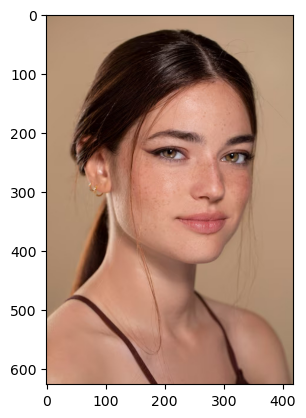

In [12]:
plt.imshow(img)

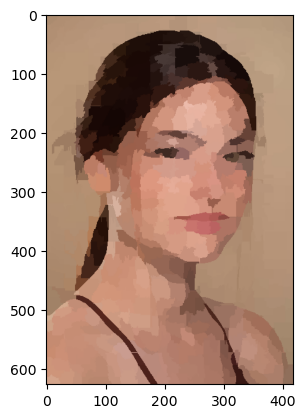

In [13]:
plt.imshow(imgS)

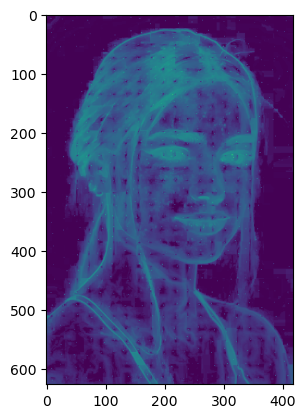

In [14]:
plt.imshow(np.log(np.maximum(1e-2, imgMask)))

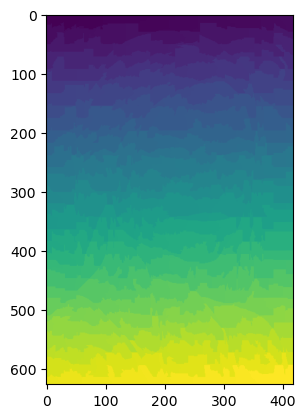

In [15]:
plt.imshow(imgIDs)

In [44]:
cv2.imwrite('Example Photos/Fin2W.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2.imwrite('Example Photos/Fin2SLICIFT.jpg', cv2.cvtColor(imgS, cv2.COLOR_RGB2BGR))

True